In [8]:
import sys
sys.path.append("../")

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scorecardpipeline as sp
from scorecardpipeline import *


In [12]:
sp

<module 'scorecardpipeline' from '/Users/seanxiao/Projects/scorecardpipeline/examples/../scorecardpipeline/__init__.py'>

In [13]:
logger = sp.init_setting(seed=6666, logger=True)

In [14]:
target = "creditability"
data = germancredit()
data[target] = data[target].map({"good": 0, "bad": 1})

# 随机替换 20% 的数据为 np.nan
for col in data.columns.drop(target):
    for i in range(len(data)):
        if np.random.rand() > 0.8:
            data[col].loc[i] = np.nan

data.head()

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account_and_bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors_or_guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,creditability
0,... < 0 DM,6.0000,NaN,NaN,1169.0000,unknown/ no savings account,NaN,4.0000,male : divorced/separated,none,...,real estate,67.0000,none,own,NaN,skilled employee / official,1.0000,"yes, registered under the customers name",yes,0
1,NaN,48.0000,existing credits paid back duly till now,NaN,5951.0000,... < 100 DM,1 <= ... < 4 years,2.0000,male : divorced/separated,none,...,real estate,NaN,none,own,1.0000,skilled employee / official,1.0000,none,yes,1
2,no checking account,12.0000,critical account/ other credits existing (not at this bank),education,NaN,NaN,4 <= ... < 7 years,2.0000,male : divorced/separated,NaN,...,NaN,49.0000,NaN,own,1.0000,unskilled - resident,2.0000,NaN,yes,0
3,... < 0 DM,NaN,existing credits paid back duly till now,furniture/equipment,7882.0000,... < 100 DM,NaN,NaN,male : divorced/separated,guarantor,...,building society savings agreement/ life insurance,45.0000,NaN,for free,1.0000,skilled employee / official,NaN,none,NaN,0
4,... < 0 DM,24.0000,NaN,car (new),4870.0000,NaN,1 <= ... < 4 years,3.0000,male : divorced/separated,none,...,unknown / no property,53.0000,none,for free,NaN,NaN,2.0000,none,yes,1


In [15]:
train, test = train_test_split(data, test_size=0.3, shuffle=True, stratify=data[target])

logger.info(f"训练集数据: {train.shape}, 测试集数据: {test.shape}")

[ 2025-03-02 21:08:00,883 ][ INFO ][ 3133036894.py:<module>:3 ] 训练集数据: (700, 21), 测试集数据: (300, 21)


In [16]:
# 模拟实际场景中的数据， date 为数据集中的日期，为 datetime 类型，实际生产过程中可能是 申请时间｜放款时间｜入催时间｜流失时间 等

df = pd.DataFrame()
df["date"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="5H")
df[target] = np.random.randint(0, 2, len(df))

total_count = len(data)
dataset_summary = pd.DataFrame(
    [
        ["建模样本", "2022-01-01", "2023-01-31", len(data), len(data) / total_count, data[target].sum(), data[target].sum() / len(data), ""],
        ["训练集", "2022-01-01", "2023-12-31", len(train), len(train) / total_count, train[target].sum(), train[target].sum() / len(train), ""],
        ["测试集", "2022-01-01", "2023-12-31", len(test), len(test) / total_count, test[target].sum(), test[target].sum() / len(test), ""],
    ],
    columns=["数据集", "开始时间", "结束时间", "样本总数", "样本占比", "坏客户数", "坏客户占比", "备注"],
)

dataset_summary

,数据集,开始时间,结束时间,样本总数,样本占比,坏客户数,坏客户占比,备注
0,建模样本,2022-01-01,2023-01-31,1000,1.0000,300,0.3000,
1,训练集,2022-01-01,2023-12-31,700,0.7000,210,0.3000,
2,测试集,2022-01-01,2023-12-31,300,0.3000,90,0.3000,


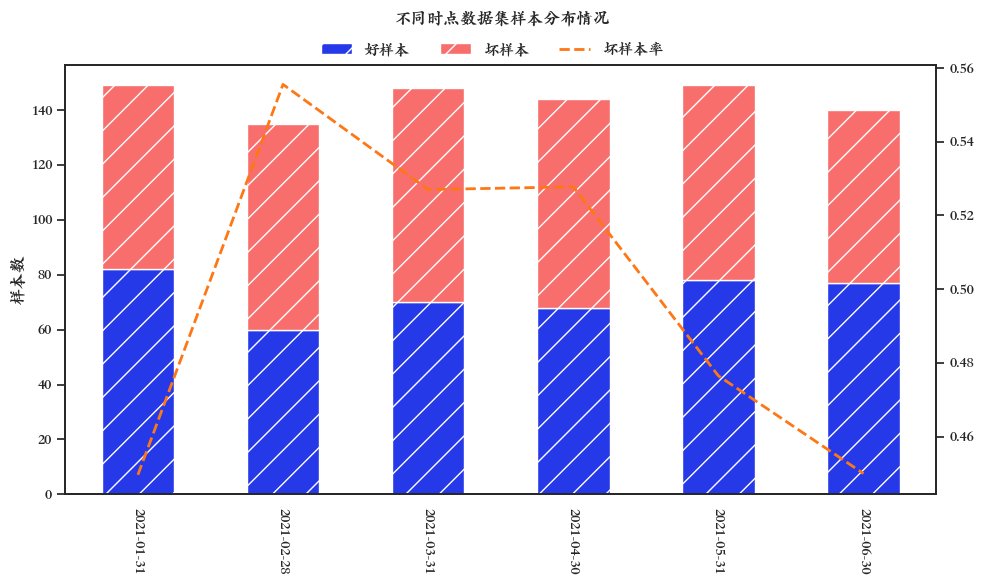

In [17]:
distribution_plot(df, date="date", target=target)

In [18]:
select = FeatureSelection(target=target, engine="toad", identical=0.95, empty=0.95, iv=0.02, corr=0.6)
select.fit(train)

train_select = select.transform(train)
test_select = select.transform(test)

In [21]:
train_select.head()
select.dropped

,variable,rm_reason
0,present_residence_since,iv
1,number_of_existing_credits_at_this_bank,iv
2,job,iv
3,telephone,iv


In [19]:
combiner = Combiner(target=target, min_bin_size=0.2, empty_separate=True)

combiner.fit(train_select)

train_bins = combiner.transform(train_select)
test_bins = combiner.transform(test_select)

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,坏账改善,累积LIFT值,累积坏账改善,累积好样本数,累积坏样本数,分档KS值
0,credit_amount,信用额度,"[负无穷 , 4000.0)",431,0.6157,325,0.6633,106,0.5048,0.2459,0.2731,0.0433,0.1158,0.8198,-0.2887,1.0000,0.0000,490,210,0.0000
1,credit_amount,信用额度,"[4000.0 , 正无穷)",139,0.1986,80,0.1633,59,0.2810,0.4245,-0.5428,0.0639,0.1158,1.4149,0.1028,1.2887,0.1802,165,104,0.1585
2,credit_amount,信用额度,缺失值,130,0.1857,85,0.1735,45,0.2143,0.3462,-0.2113,0.0086,0.1158,1.1538,0.0351,1.1538,0.0351,85,45,0.0408


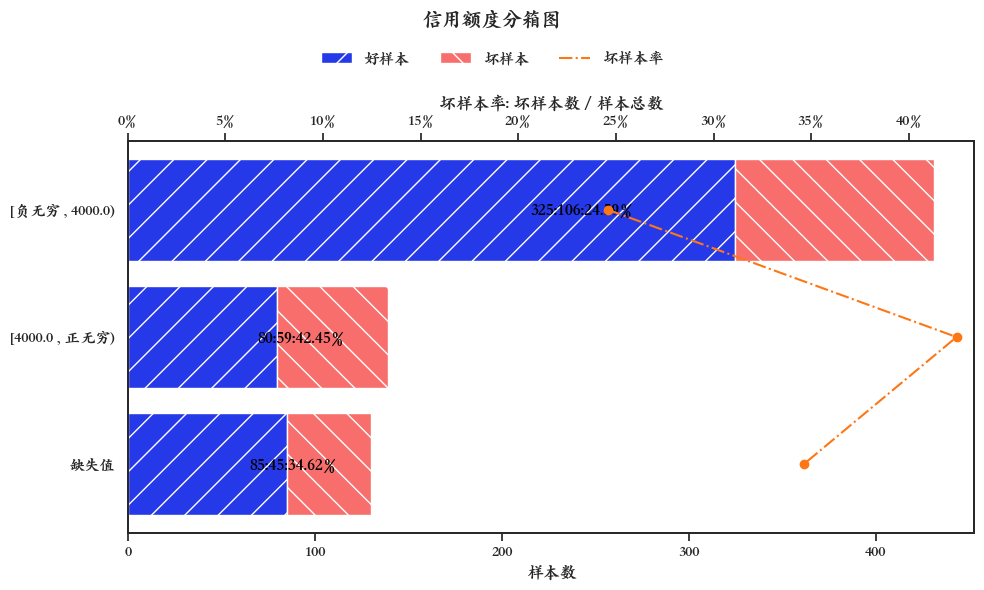

: 

In [11]:
combiner.bin_plot(train_select, "credit_amount", result=True, desc="信用额度", rule=[4000.0, np.nan])

In [12]:
transform = WOETransformer(target=target)
transform.fit(train_bins)

train_woe = transform.transform(train_bins)
test_woe = transform.transform(test_bins)

: 

In [13]:
# 初始化逐步回归特征筛选器
stepwise = StepwiseSelection(target=target)
# 训练
stepwise.fit(train_woe)
# 应用逐步回归特征筛选器
train_woe_stepwise = stepwise.transform(train_woe)
test_woe_stepwise = stepwise.transform(test_woe)

: 

In [14]:
# 逻辑回归模型构建
logistic = ITLubberLogisticRegression(target=target)
# 训练
logistic.fit(train_woe_stepwise)
# 预测数据集样本违约概率
y_pred_train = logistic.predict_proba(train_woe_stepwise.drop(columns=target))[:, 1]
y_pred_test = logistic.predict_proba(test_woe_stepwise.drop(columns=target))[:, 1]

: 

In [15]:
# 数据字典或特征描述信息
feature_map = {
    "const": "截距项",
    "status_of_existing_checking_account": "现有支票账户的状态",
    "credit_history": "信用记录",
    "purpose": "目的",
    "credit_amount": "信用额度",
    "present_employment_since": "现居住地至今",
    "installment_rate_in_percentage_of_disposable_income": "分期付款率占可支配收入的百分比",
    "personal_status_and_sex": "个人地位和性别",
    "age_in_years": "年龄",
    "housing": "住房情况",
}
# summary 仅支持输出简单的统计信息，使用 summary2 可以输出有特征描述的统计信息表
logistic.summary2(feature_map=feature_map)

,Features,Describe,Coef.,Std.Err,z,P>|z|,[ 0.025,0.975 ],VIF
0,const,截距项,-0.8423,0.0942,-8.9407,0.0000,-1.0269,-0.6576,1.0499
1,status_of_existing_checking_account,现有支票账户的状态,0.9018,0.1295,6.9653,0.0000,0.6480,1.1555,1.0828
2,purpose,目的,1.0039,0.3082,3.2577,0.0011,0.3999,1.6079,1.0108
3,credit_amount,信用额度,1.1053,0.2571,4.2988,0.0000,0.6014,1.6093,1.0346
4,savings_account_and_bonds,,0.6072,0.2516,2.4130,0.0158,0.1140,1.1004,1.0635
5,present_employment_since,现居住地至今,0.6739,0.3667,1.8379,0.0661,-0.0448,1.3926,1.0612
6,installment_rate_in_percentage_of_disposable_income,分期付款率占可支配收入的百分比,1.2856,0.4382,2.9338,0.0033,0.4267,2.1444,1.0178
7,personal_status_and_sex,个人地位和性别,0.8099,0.5258,1.5404,0.1235,-0.2206,1.8405,1.0106
8,property,,0.8269,0.3841,2.1527,0.0313,0.0740,1.5797,1.0279
9,age_in_years,年龄,0.9057,0.2749,3.2946,0.0010,0.3669,1.4445,1.0459


: 

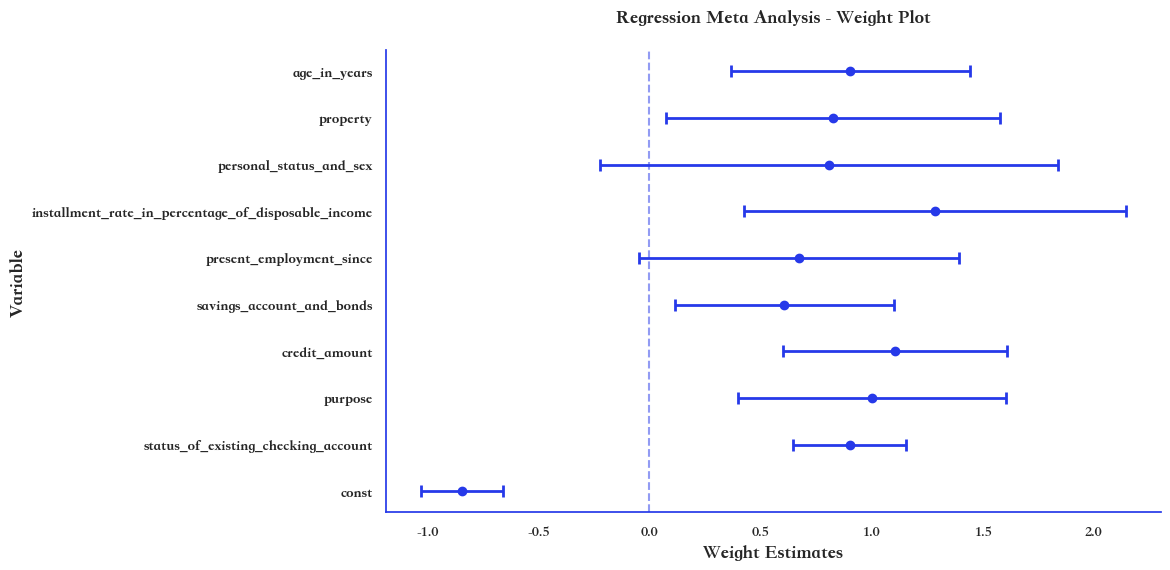

: 

In [16]:
logistic.plot_weights(figsize=(10, 6), save="model_report/sp_lr_weight.png");

In [17]:
bad_rate = train[target].mean()
# 逻辑回归模型转评分卡
card = ScoreCard(target=target, combiner=combiner, transer=transform, pretrain_lr=logistic, base_score=50, base_odds=(1 - bad_rate) / bad_rate, pdo=10)
# 训练
card.fit(train_woe_stepwise)

# 预测
train["score"] = card.predict(train)
test["score"] = card.predict(test)

: 

: 

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,坏账改善,累积LIFT值,累积坏账改善,累积好样本数,累积坏样本数,分档KS值
0,score,训练集模型评分,"[负无穷 , 40)",111,0.1586,41,0.0837,70,0.3333,0.6306,-1.3822,0.3451,0.8421,2.1021,0.2077,2.1021,0.2077,41,70,0.2497
1,score,训练集模型评分,"[40 , 60)",301,0.4300,195,0.3980,106,0.5048,0.3522,-0.2377,0.0254,0.8421,1.1739,0.1312,1.4239,0.6065,236,176,0.3565
2,score,训练集模型评分,"[60 , 80)",227,0.3243,196,0.4000,31,0.1476,0.1366,0.9968,0.2516,0.8421,0.4552,-0.2615,1.0798,0.8361,432,207,0.1041
3,score,训练集模型评分,"[80 , 正无穷)",61,0.0871,58,0.1184,3,0.0143,0.0492,2.1145,0.2201,0.8421,0.1639,-0.0798,1.0000,0.0000,490,210,0.0000


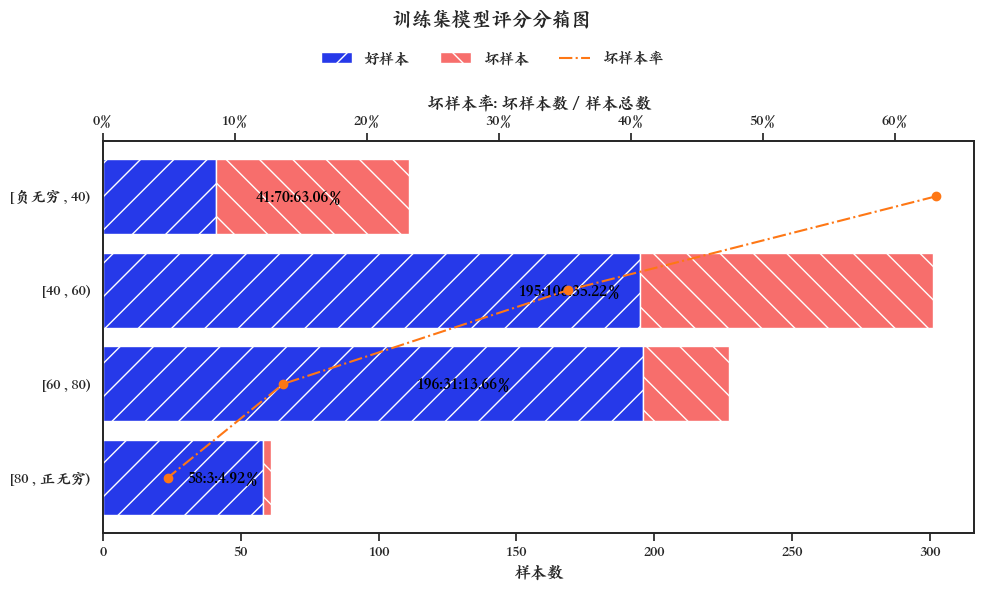

: 

In [18]:
# 训练集评分排序性
score_clip = card.score_clip(train["score"], clip=20)
score_table_train = feature_bin_stats(train, "score", desc="训练集模型评分", target=target, rules=score_clip)
bin_plot(score_table_train, desc="训练集模型评分", figsize=(10, 6), anchor=0.935, save="model_report/train_score_bins.png")

display(score_table_train)

In [19]:
"savings_account_and_bonds" in combiner

True

: 

In [20]:
feature_bins(np.array(combiner["savings_account_and_bonds"]))

{0: 'unknown/ no savings account,... >= 1000 DM,500 <= ... < 1000 DM',
 1: '... < 100 DM,100 <= ... < 500 DM',
 -1: '缺失值'}

: 

In [21]:
# # 查看某个特征的 PSI
# score_clip = card.score_clip(train["score"], clip=10)
# score_table_train = feature_bin_stats(train, "score", desc="训练集模型评分", target=target, rules=score_clip)
# score_table_test = feature_bin_stats(test, "score", desc="测试集模型评分", target=target, rules=score_clip)
# train_test_score_psi = psi_plot(score_table_train, score_table_test, labels=["训练数据集", "测试数据集"], save="model_report/train_test_psiplot.png", result=True)

# # 查看某个入模特征的 CSI
# for col in card._feature_names:
#     feature_table_train = feature_bin_stats(train, col, target=target, desc="训练集分布", combiner=combiner)
#     feature_table_test = feature_bin_stats(test, col, target=target, desc="测试集分布", combiner=combiner)
#     train_test_csi_table = csi_plot(feature_table_train, feature_table_test, card[col], desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练数据集", "测试数据集"], save=f"model_report/csi_{col}.png")
#     if col == "savings_account_and_bonds": break

: 

: 

In [22]:
# for col in card._feature_names:
#     print(col)
#     feature_table = feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
#     _ = sp.bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4), anchor=0.9)
    
#     display(feature_table)
#     plt.show()

: 

In [23]:
card["age_in_years"]

{'bins': array([35., nan]),
 'woes': array([ 0.35631058, -0.40546511, -0.08982696]),
 'weight': 0.9057217143033184,
 'scores': array([ 0.89168832, 10.84566059,  6.7212793 ])}

: 

In [24]:
save_pickle(card, "model_report/scorecard.pkl")

: 

In [30]:
# scorecard_pipeline = card.scorecard2pmml(pmml="model_report/scorecard.pmml", debug=True)

: 

In [28]:
# pd.DataFrame({"pred": scorecard_pipeline.predict(train), "true": train["score"]})

: 

In [32]:
# 导入超参数搜索方法
from sklearn.model_selection import GridSearchCV

# 构建 pipeline
model_pipeline = Pipeline([
    ("preprocessing", FeatureSelection(target=target, engine="toad")),
    ("combiner", Combiner(target=target, min_bin_size=0.2, adj_rules=None)),
    ("transform", WOETransformer(target=target)),
    ("processing_select", FeatureSelection(target=target, engine="toad")),
    ("stepwise", StepwiseSelection(target=target)),
    ("logistic", ITLubberLogisticRegression(target=target)),
])

params_grid = {
    "combiner__max_n_bins": [3],
    "logistic__C": [np.power(2, i) for i in range(5)],
    "logistic__penalty": ["l2"],
    "logistic__class_weight": [None, "balanced"] + [{1: i / 10.0, 0: 1 - i / 10.0} for i in range(1, 10, 2)],
    "logistic__max_iter": [10, 50, 100],
    "logistic__solver": ["sag"], # ["liblinear", "sag", "lbfgs", "newton-cg"],
}

pipeline_grid_search = GridSearchCV(model_pipeline, params_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1, return_train_score=True)
pipeline_grid_search.fit(train, train[target], error_score='raise')

print(pipeline_grid_search.best_params_)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


ValueError: 
All the 315 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
315 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 422, in fit
    fit_params_steps = self._check_fit_params(**fit_params)
  File "/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in _check_fit_params
    raise ValueError(
ValueError: Pipeline.fit does not accept the error_score parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.


: 

In [29]:
# 构建 pipeline
model_pipeline = Pipeline([
    ("preprocessing", FeatureSelection(target=target, engine="scorecardpy")),
    ("combiner", Combiner(target=target, min_bin_size=0.2)),
    ("transform", WOETransformer(target=target)),
    ("processing_select", FeatureSelection(target=target, engine="toad")),
    ("stepwise", StepwiseSelection(target=target)),
    ("logistic", ITLubberLogisticRegression(target=target)),
])
# 训练 pipeline
model_pipeline.fit(train)
# 转换评分卡
card = ScoreCard(target=target, pipeline=model_pipeline, base_score=50, base_odds=(1 - bad_rate) / bad_rate, pdo=10)
card.fit(model_pipeline[:-1].transform(train))
print(card.scorecard_points().to_markdown())

[INFO] filtering variables ...
|    | 变量名称                                            | 变量分箱                                                                                                                             |   对应分数 |
|---:|:----------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|-----------:|
|  0 | property                                            | real estate                                                                                                                          |    11.2541 |
|  1 | property                                            | unknown / no property,building society savings agreement/ life insurance,car or other, not in attribute Savings account/bonds,缺失值 |     4.0428 |
|  2 | present_employment_since                            | ... >= 7 years,4 <= ... < 7 years                                                      

: 

In [30]:
card.scorecard_points()

,变量名称,变量分箱,对应分数
0,property,real estate,11.2541
1,property,"unknown / no property,building society savings agreement/ life insurance,car or other, not in attribute Savings account/bonds,缺失值",4.0428
2,present_employment_since,"... >= 7 years,4 <= ... < 7 years",9.4896
3,present_employment_since,"1 <= ... < 4 years,... < 1 year,unemployed,缺失值",3.8957
4,credit_amount,"[负无穷 , 2145.0)",8.0057
5,credit_amount,"[2145.0 , 3804.0)",14.2751
6,credit_amount,"[3804.0 , 正无穷)",-2.6347
7,credit_amount,缺失值,2.1778
8,installment_rate_in_percentage_of_disposable_income,"[负无穷 , 4.0)",7.7878
9,installment_rate_in_percentage_of_disposable_income,"[4.0 , 正无穷)",0.9877


: 

: 

In [49]:
bad_rate = train[target].mean()
# 逻辑回归模型转评分卡
card = ScoreCard(target=target, pipeline=mdoel_pipeline, base_score=50, base_odds=(1 - bad_rate) / bad_rate, pdo=10)
# 训练
card.fit(mdoel_pipeline[:-1].transform(train))
card.scorecard_points()

,变量名称,变量分箱,对应分数
0,purpose,"radio/television,car (used)",12.8514
1,purpose,"business,furniture/equipment,others,education,domestic appliances,retraining,car (new),缺失值,repairs",2.7818
2,installment_rate_in_percentage_of_disposable_income,"[负无穷 , 4.0)",7.7878
3,installment_rate_in_percentage_of_disposable_income,"[4.0 , 正无穷)",0.9877
4,installment_rate_in_percentage_of_disposable_income,缺失值,10.7462
5,savings_account_and_bonds,"500 <= ... < 1000 DM,unknown/ no savings account,... >= 1000 DM",5.9834
6,savings_account_and_bonds,"... < 100 DM,100 <= ... < 500 DM",12.1585
7,savings_account_and_bonds,缺失值,3.2466
8,present_employment_since,"4 <= ... < 7 years,... >= 7 years",9.4896
9,present_employment_since,"缺失值,unemployed,1 <= ... < 4 years,... < 1 year",3.8957


: 

In [95]:
# 数据字段[可选]
feature_describe = pd.DataFrame([
    ["status_account", "支票账户状态"], ["duration", "借款周期"], ["credit_histor", "历史信用"], ["purpose", "借款目的"], ["amount", "信用额度"], ["svaing_account", "储蓄账户状态"], ["present_emp", "当前就业状态"], ["income_rate", "分期付款占可支配收入百分比"], ["personal_status", "性别与婚姻状态"], ["other_debtors", "他人担保信息"], ["residence_info", "现居住地"], ["property", "财产状态"], ["age", "年龄"], ["inst_plans", "其他分期情况"], ["housing", "房产状态"], ["num_credits", "信用卡数量"], ["job", "工作状态"], ["dependents", "赡养人数"], ["telephone", "电话号码注册情况"], ["foreign_worke", "是否有海外工作经历"],
], columns=["变量名称", "变量含义"])
feature_map = dict(zip(feature_describe["变量名称"], feature_describe["变量含义"]))

: 

In [96]:
writer = sp.ExcelWriter()
start_row, start_col = 2, 2

: 

In [97]:
# # ////////////////////////////////////// 样本说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("汇总信息")

# 样本总体分布情况
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="样本总体分布情况", style="header")
end_row, end_col = sp.dataframe2excel(dataset_summary, writer, worksheet, percent_cols=["样本占比", "坏客户占比"], start_row=end_row + 1)

# 建模样本时间分布情况
temp = sp.distribution_plot(df, date="date", target=target, save="model_report/all_sample_time_count.png", result=True)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/all_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = sp.dataframe2excel(temp, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率"], condition_cols=["坏样本率"], start_row=end_row)

: 

In [98]:
# ////////////////////////////////////// 模型报告 ///////////////////////////////////// #
summary = logistic.summary2(feature_map=feature_map)

# 逻辑回归拟合情况
worksheet = writer.get_sheet_by_name("逻辑回归拟合结果")

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="逻辑回归拟合效果", style="header")
end_row, end_col = sp.dataframe2excel(summary, writer, worksheet, condition_cols=["Coef."], start_row=end_row + 1)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集拟合报告", style="header")
end_row, end_col = sp.dataframe2excel(logistic.report(train_woe_stepwise), writer, worksheet, percent_cols=["precision", "recall", "f1-score"], start_row=end_row + 1)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集拟合报告", style="header")
end_row, end_col = sp.dataframe2excel(logistic.report(test_woe_stepwise), writer, worksheet, percent_cols=["precision", "recall", "f1-score"], start_row=end_row + 1)

: 

In [105]:
# ////////////////////////////////////// 特征概述 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型变量信息")

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量信息", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, feature_describe.reset_index().rename(columns={"index": "序号"}), (end_row + 1, start_col))

# 变量分布情况
import toad
data_info = toad.detect(data[card.rules.keys()]).reset_index().rename(columns={"index": "变量名称", "type": "变量类型", "size": "样本个数", "missing": "缺失值", "unique": "唯一值个数"})
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, data_info, (end_row + 1, start_col))

# 变量相关性
data_corr = train_woe_stepwise.corr()
logistic.corr(train_woe_stepwise, save="model_report/train_corr.png", annot=False)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量相关性", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_corr.png", (end_row + 1, start_col), figsize=(700, 500))
end_row, end_col = sp.dataframe2excel(data_corr.reset_index().rename(columns={"index": ""}), writer, worksheet, color_cols=list(data_corr.columns), start_row=end_row + 1)

# 变量分箱信息
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分箱信息", style="header")

for col in logistic.feature_names_in_:
    feature_table = sp.feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    _ = sp.bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4), save=f"model_report/bin_plots/data_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/bin_plots/data_{col}.png", (end_row + 1, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(feature_table, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"], condition_cols=["坏样本率", "LIFT值"], start_row=end_row)

: 

In [106]:
# ////////////////////////////////////// 评分卡说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("评分卡结果")

# 评分卡刻度
scorecard_kedu = card.scorecard_scale()
scorecard_points = card.scorecard_points(feature_map=feature_map)
scorecard_clip = card.score_clip(train["score"], clip=100)

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="评分卡刻度", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_kedu, (end_row + 1, start_col))

# 评分卡对应分数
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡分数", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_points, (end_row + 1, start_col), merge_column="变量名称")

# 评分效果
score_table_train = sp.feature_bin_stats(train, "score", desc="测试集模型评分", target=target, rules=scorecard_clip)
score_table_test = sp.feature_bin_stats(test, "score", desc="测试集模型评分", target=target, rules=scorecard_clip)

sp.ks_plot(train["score"], train[target], title="Train \tDataset", save="model_report/train_ksplot.png")
sp.ks_plot(test["score"], test[target], title="Test \tDataset", save="model_report/test_ksplot.png")

sp.hist_plot(train["score"], train[target], save="model_report/train_scorehist.png", bins=30)
sp.hist_plot(test["score"], test[target], save="model_report/test_scorehist.png", bins=30)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_scorehist.png", (ks_row, end_col))
end_row, end_col = sp.dataframe2excel(score_table_train, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"], condition_cols=["坏样本率", "LIFT值", "分档KS值"], start_row=end_row + 1)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_scorehist.png", (ks_row, end_col))
end_row, end_col = sp.dataframe2excel(score_table_test, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"], condition_cols=["坏样本率", "LIFT值", "分档KS值"], start_row=end_row + 1)

: 

In [108]:
# ////////////////////////////////////// 模型稳定性 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型稳定性")
start_row, start_col = 2, 2

# 评分分布稳定性
train_test_score_psi = sp.psi_plot(score_table_train, score_table_test, labels=["训练数据集", "测试数据集"], save="model_report/train_test_psiplot.png", result=True)

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="模型评分稳定性指标 (Population Stability Index, PSI): 训练数据集 vs 测试数据集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_test_psiplot.png", (end_row, start_col), figsize=(800, 400))
end_row, end_col = sp.dataframe2excel(train_test_score_psi, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"], condition_cols=["分档PSI值"], start_row=end_row + 1)

# 变量 PSI 表
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    psi_table = sp.psi_plot(feature_table_train, feature_table_test, desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练数据集", "测试数据集"], save=f"model_report/psi_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/psi_{col}.png", (end_row, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(psi_table, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率", "测试数据集% - 训练数据集%"], condition_cols=["分档PSI值"], start_row=end_row + 1)

# 变量 CSI 表
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="入模变量稳定性指标 (Characteristic Stability Index, CSI): 训练数据集 vs 测试数据集", style="header")

for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    train_test_csi_table = sp.csi_plot(feature_table_train, feature_table_test, card[col], desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练数据集", "测试数据集"], save=f"model_report/csi_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/csi_{col}.png", (end_row, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(train_test_csi_table, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率", "测试数据集% - 训练数据集%"], condition_cols=["分档CSI值"], start_row=end_row + 1)

: 

: 

In [109]:
writer.save("model_report/评分卡模型报告.xlsx")

: 